In [23]:
import argparse
import datetime
import backtrader as bt 
import backtrader.indicators as btind
import backtrader.analyzers as btanalyzers
import backtrader.feeds as btfeeds
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [24]:
class RSI(bt.Strategy):
	params=(('min_RSI',35),('max_RSI',65),('max_position',10),('look_back_period',14))

	def log(self, txt, dt=None):
		dt = dt or self.datas[0].datetime.date(0)
		print('%s, %s' % (dt.isoformat(), txt))

	def __init__(self):
		# RSI indicator
		self.RSI = bt.indicators.RSI_SMA(self.data.close, period=self.params.look_back_period) 

	def notify_order(self, order):
		if order.status in [order.Submitted, order.Accepted]:
		# Buy/Sell order submitted/accepted to/by broker - Nothing to do
			return

		# Check if an order has been completed
		# Attention: broker could reject order if not enough cash
		if order.status in [order.Completed]:
			if order.isbuy():
				self.log('BUY EXECUTED, %.2f' % order.executed.price)
			elif order.issell():
				self.log('SELL EXECUTED, %.2f' % order.executed.price)

			self.bar_executed = len(self)

		elif order.status in [order.Canceled, order.Margin, order.Rejected]:
			self.log('Order Canceled/Margin/Rejected')

		# Write down: no pending order
		self.order = None

	def next(self):

		# Buy if over sold
		if self.RSI < self.params.min_RSI:
			self.buy()

		# Sell if over buyed
		if self.RSI > self.params.max_RSI:
			self.close()

In [26]:
# Create a cerebro entity
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(RSI)

0

In [27]:
# Create a Data Feed
data = bt.feeds.YahooFinanceData(
        dataname='AAPL',
        # Do not pass values before this date
        fromdate=datetime.datetime(2014, 1, 1),
        # Do not pass values before this date
        todate=datetime.datetime(2019, 12, 31),
        # Do not pass values after this date
        reverse=False)

In [28]:
# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(10000.0)

# Add a FixedSize sizer according to the stake
cerebro.addsizer(bt.sizers.FixedSize, stake=100)

# Set the commission
cerebro.broker.setcommission(commission=0.0)

In [29]:
# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 10000.00


In [30]:
# Run over everything
cerebro.run()

2014-01-30, BUY EXECUTED, 16.01
2014-02-05, BUY EXECUTED, 16.14
2014-02-06, BUY EXECUTED, 16.35
2014-02-07, BUY EXECUTED, 16.71
2014-02-19, SELL EXECUTED, 17.46
2014-04-14, BUY EXECUTED, 16.73
2014-04-15, BUY EXECUTED, 16.68
2014-04-16, BUY EXECUTED, 16.61
2014-04-17, BUY EXECUTED, 16.67
2014-04-28, SELL EXECUTED, 18.36
2014-10-17, BUY EXECUTED, 22.11
2014-10-24, SELL EXECUTED, 23.85
2014-12-15, BUY EXECUTED, 25.21
2014-12-16, BUY EXECUTED, 24.22
2014-12-17, BUY EXECUTED, 24.40
2014-12-18, BUY EXECUTED, 25.48
2015-01-20, Order Canceled/Margin/Rejected
2015-01-27, SELL EXECUTED, 25.60
2015-03-16, BUY EXECUTED, 28.32
2015-03-17, BUY EXECUTED, 28.79
2015-04-28, SELL EXECUTED, 30.74
2015-06-15, BUY EXECUTED, 28.95
2015-06-17, BUY EXECUTED, 29.32
2015-06-18, BUY EXECUTED, 29.21
2015-06-22, BUY EXECUTED, 29.27
2015-07-09, Order Canceled/Margin/Rejected
2015-07-10, Order Canceled/Margin/Rejected
2015-07-21, SELL EXECUTED, 30.50
2015-08-04, BUY EXECUTED, 26.96
2015-08-05, BUY EXECUTED, 25.93
2

In [31]:
# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Final Portfolio Value: 13469.00


<IPython.core.display.Javascript object>

[[<Figure size 432x288 with 5 Axes>]]

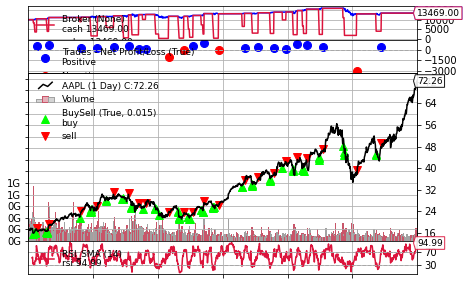

In [37]:
# Plot the result
cerebro.plot()